In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

### Define paths for the model and data of interest

In [2]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/profile/"
chrom_set = ["chr1"]
input_length = 1346
profile_length = 1000
fourier_att_prior_freq_limit = 200
fourier_att_prior_freq_limit_softness = 0.2
att_prior_grad_smooth_sigma = 3

In [32]:
# SPI1
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/profile/config/SPI1/SPI1_training_paths.json")
num_tasks = 4
num_strands = 2
controls = "matched"
task_index = None
model_class = profile_models.ProfilePredictorWithMatchedControls
noprior_model_path = os.path.join(model_base_path, "SPI1_keep1/20/model_ckpt_epoch_20.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior_keep1/15/model_ckpt_epoch_20.pt")

In [56]:
# GATA2
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/profile/config/GATA2/GATA2_training_paths.json")
num_tasks = 3
num_strands = 2
controls = "matched"
task_index = None
model_class = profile_models.ProfilePredictorWithMatchedControls
noprior_model_path = os.path.join(model_base_path, "GATA2_keep1/23/model_ckpt_epoch_15.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior_keep1/26/model_ckpt_epoch_20.pt")

In [3]:
# K562
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/profile/config/K562/K562_training_paths.json")
num_tasks = 1
num_strands = 1
controls = "shared"
task_index = None
model_class = profile_models.ProfilePredictorWithSharedControls
noprior_model_path = os.path.join(model_base_path, "K562/10/model_ckpt_epoch_19.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/5/model_ckpt_epoch_18.pt")

In [96]:
# BPNet
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/profile/config/BPNet_training_paths.json")
num_tasks = 3
num_strands = 2
controls = "shared"
task_index = 0  # Focus on Nanog only, for now
model_class = profile_models.ProfilePredictorWithSharedControls
noprior_model_path = os.path.join(model_base_path, "BPNet/15/model_ckpt_epoch_17.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/7/model_ckpt_epoch_18.pt")

In [4]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [5]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [6]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates to data needed for the model

In [7]:
input_func = data_loading.get_profile_input_func(
    files_spec_path, input_length, profile_length, reference_fasta
)
pos_coords = data_loading.get_positive_profile_coords(
    files_spec_path, chrom_set=chrom_set, task_ind=task_index
)

### SHAP explainers
Create DeepSHAP explainers

In [8]:
noprior_shap_explainer = compute_shap.create_profile_explainer(
    noprior_model, input_length, profile_length, num_tasks, num_strands, controls,
    task_index=task_index
)

In [9]:
prior_shap_explainer = compute_shap.create_profile_explainer(
    prior_model, input_length, profile_length, num_tasks, num_strands, controls,
    task_index=task_index
)

### Compute loss values over test set

In [10]:
# Sample a subset of peaks randomly to compute predictions for
num_samples = 1000
sample_coords = pos_coords[np.random.choice(len(pos_coords), size=num_samples, replace=False)]

In [11]:
# Add a random jitter to avoid center-bias
jitters = np.random.randint(-128, 128 + 1, size=len(sample_coords))
sample_coords[:, 1] = sample_coords[:, 1] + jitters
sample_coords[:, 2] = sample_coords[:, 2] + jitters

In [12]:
noprior_preds = compute_predictions.get_profile_model_predictions(                                              
    noprior_model, sample_coords, num_tasks, input_func, controls=controls,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


In [13]:
prior_preds = compute_predictions.get_profile_model_predictions(                                              
    prior_model, sample_coords, num_tasks, input_func, controls=controls,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


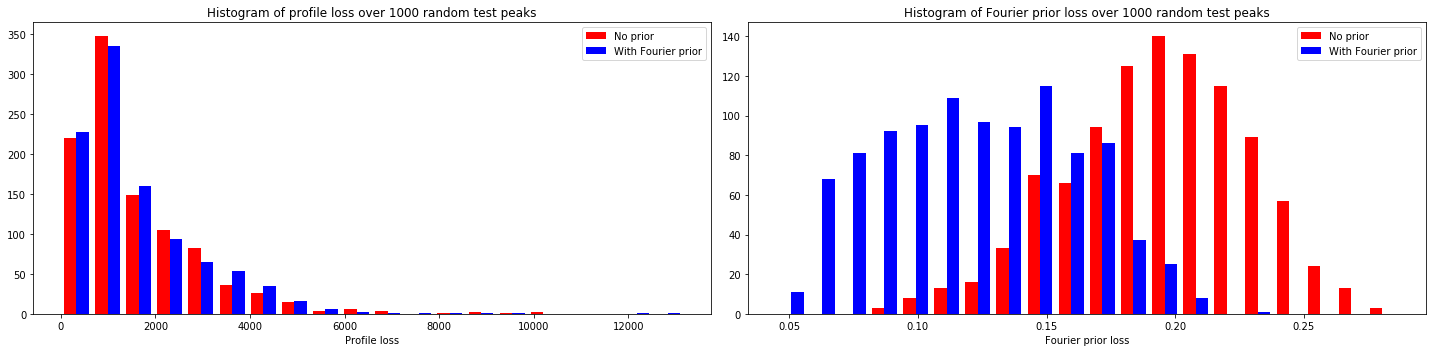

In [14]:
# Plot histogram of profile loss and prior loss over these conditions
bin_num = 20
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(
    [noprior_preds["prof_losses"], prior_preds["prof_losses"]],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
ax[0].set_title("Histogram of profile loss over %d random test peaks" % len(sample_coords))
ax[0].set_xlabel("Profile loss")
ax[0].legend()
ax[1].hist(
    [noprior_preds["att_losses"], prior_preds["att_losses"]],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
ax[1].set_title("Histogram of Fourier prior loss over %d random test peaks" % len(sample_coords))
ax[1].set_xlabel("Fourier prior loss")
ax[1].legend()
plt.tight_layout()

In [107]:
# The coordinates that show the most improvement in prior loss
sample_coords[np.flip(np.argsort(noprior_preds["att_losses"] - prior_preds["att_losses"]))][:10]

array([['chr1', 93343494, 93343838],
       ['chr1', 78657690, 78657870],
       ['chr1', 64226286, 64226586],
       ['chr1', 191897676, 191898020],
       ['chr1', 135217492, 135217792],
       ['chr1', 72244211, 72244475],
       ['chr1', 14187017, 14187361],
       ['chr1', 73685548, 73685892],
       ['chr1', 86526637, 86526839],
       ['chr1', 135194277, 135194621]], dtype=object)

### Plotting functions

In [16]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x S NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand (or unstranded), for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length, num_strands = pred_profs.shape
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 2 * num_strands))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        if num_strands == 2:
            ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
            ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)
    plt.show()

In [17]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

def plot_fft(signal, include_dc=False, pos_limit=None, title=None):
    abs_signal = np.abs(signal)
    
    freqs, mags = dft(abs_signal)
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
        
    plt.figure(figsize=(20, 2))
    plt.plot(freqs, mags, color="red")
    plt.xlabel("Frequency (radians)")
    plt.ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(signal)
        plt.axvline(x=pos_limit_radians, color="black")
    if title:
        plt.title(title)
    plt.show()

In [18]:
def plot_signal(signal, title=None):
    plt.figure(figsize=(20, 2))
    plt.plot(signal)
    if title:
        plt.title(title)
    plt.show()

### View predictions

In [19]:
def predict_and_plot(model, shap_explainer, chrom, start, end, show_sequences=True, seq_slice=slice(650, 750)):
    results = compute_predictions.get_profile_model_predictions(                                              
        model, [(chrom, start, end)] * 50, num_tasks, input_func, controls=controls,                        
        return_losses=False, return_gradients=True, show_progress=False                                         
    )
    true_profs = results["true_profs"]
    log_pred_profs = results["log_pred_profs"]
    input_seqs = results["input_seqs"]
    input_grads = results["input_grads"]

    pred_prof_probs = np.exp(log_pred_profs)
    true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
    
    # plot_profiles(pred_prof_probs[0], true_prof_probs[0])
    
    if not seq_slice:
        seq_slice = slice(None, None)
    
    print("Input gradients and Fourier transform")
    plot_signal(np.sum(input_grads[0] * input_seqs[0], axis=1), title="Input gradients")
    plot_fft(np.sum(input_grads[0] * input_seqs[0], axis=1), pos_limit=200, title="Fourier transform of input gradients")
    if show_sequences:
        viz_sequence.plot_weights(input_grads[0][seq_slice])
        viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice])
    
    print("SHAP scores")
    input_seqs, profiles = input_func([(chrom, start, end)] * 5)
    hyp_shap_scores = shap_explainer(
        input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
    )
    plot_signal(np.sum(hyp_shap_scores[0] * input_seqs[0], axis=1), title="SHAP scores")
    if show_sequences:
        viz_sequence.plot_weights(hyp_shap_scores[0][seq_slice])
        viz_sequence.plot_weights((hyp_shap_scores[0] * input_seqs[0])[seq_slice])
    
    print("ISM scores")
    hyp_ism_scores = compute_ism.get_profile_model_ism(
        model, input_seqs, cont_profs=profiles[:, num_tasks:], task_index=task_index
    )
    plot_signal(np.sum(hyp_ism_scores[0] * input_seqs[0], axis=1), title="ISM scores")
    if show_sequences:
        viz_sequence.plot_weights(hyp_ism_scores[0][seq_slice])
        viz_sequence.plot_weights((hyp_ism_scores[0] * input_seqs[0])[seq_slice])

In [ ]:
# Sample some random peaks
pos_coords[np.random.choice(len(pos_coords), size=10, replace=False)]

Input gradients and Fourier transform


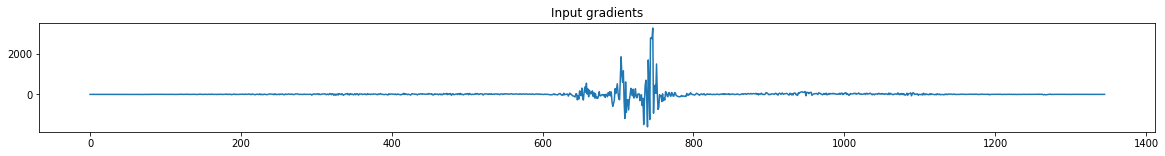

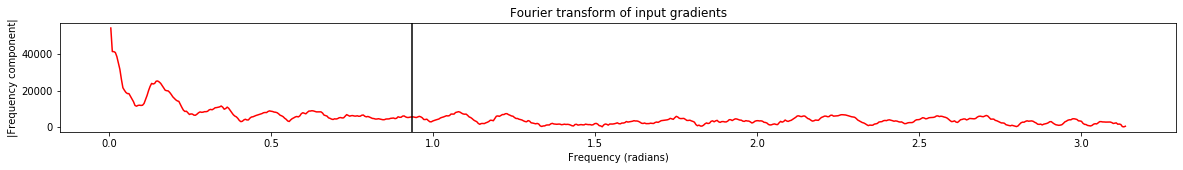

SHAP scores


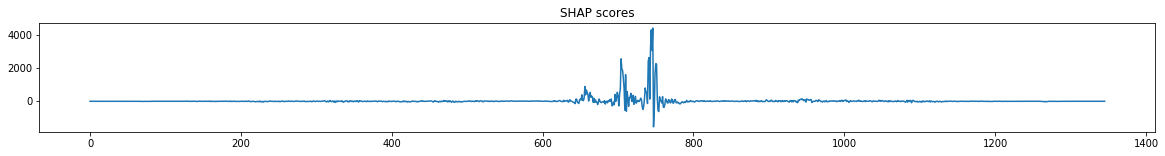

ISM scores


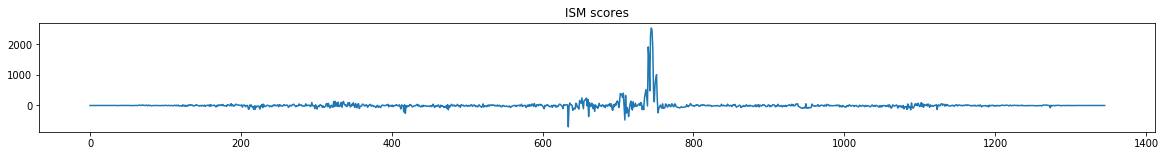

Input gradients and Fourier transform


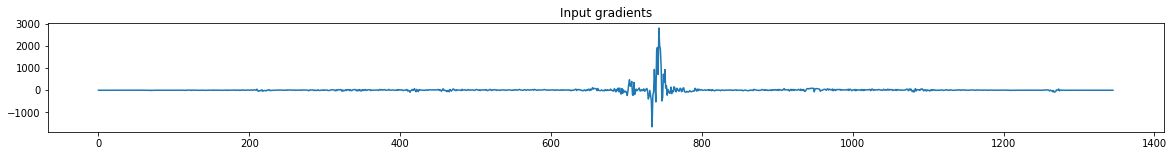

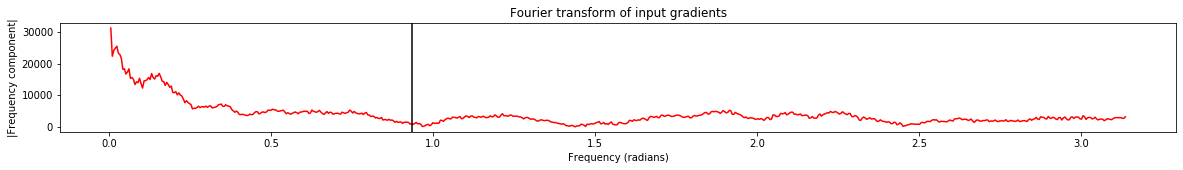

SHAP scores


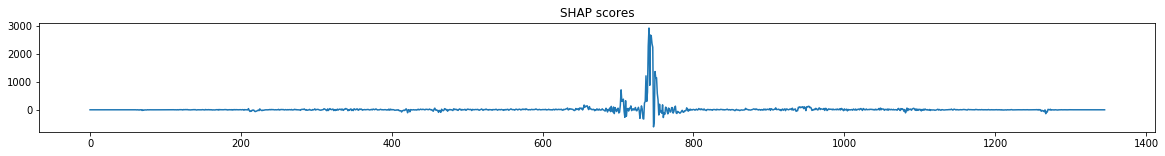

ISM scores


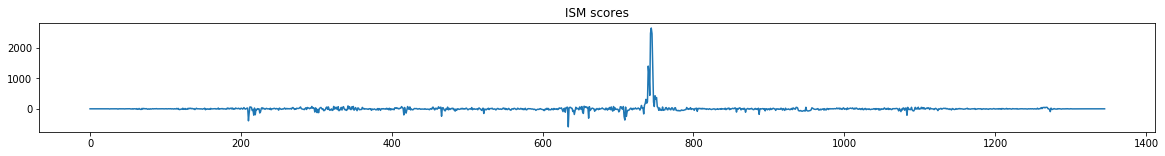

In [40]:
# SPI1
chrom, start, end = 'chr1', 2112484, 2112690
seq_slice = slice(675, 775)
show_sequences = False
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, show_sequences, seq_slice)

Input gradients and Fourier transform


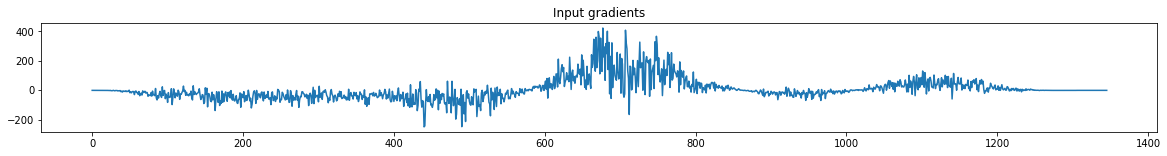

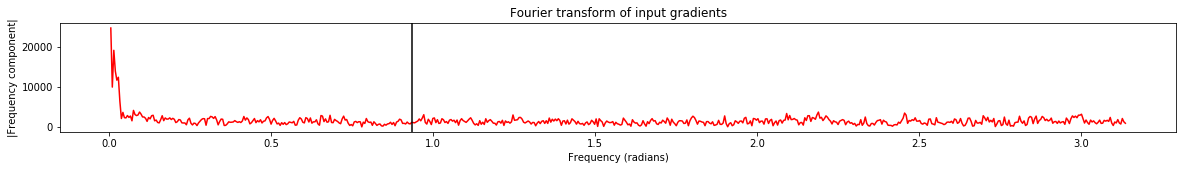

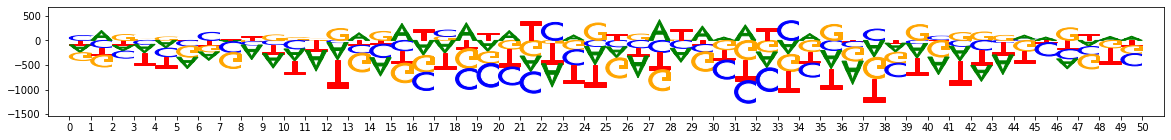

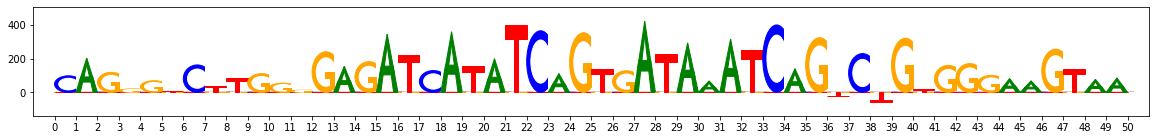

SHAP scores


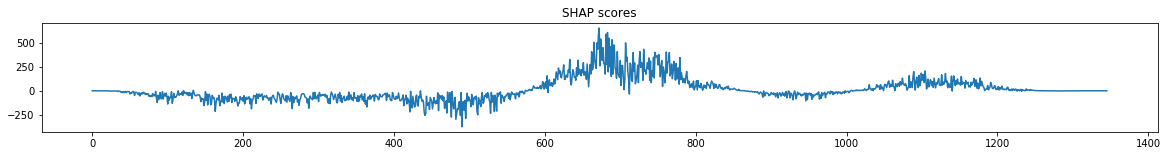

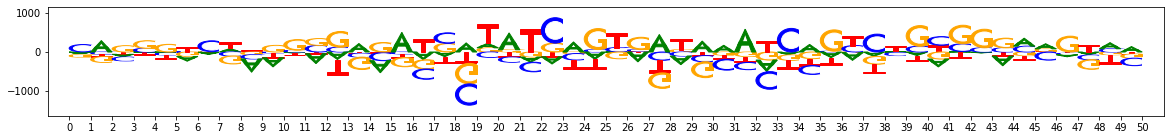

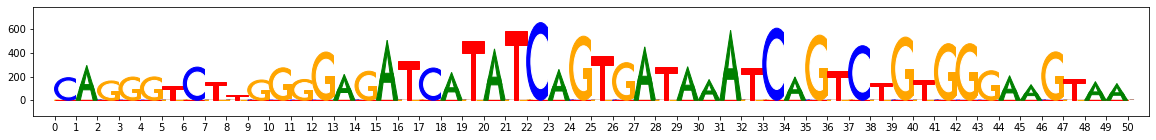

ISM scores


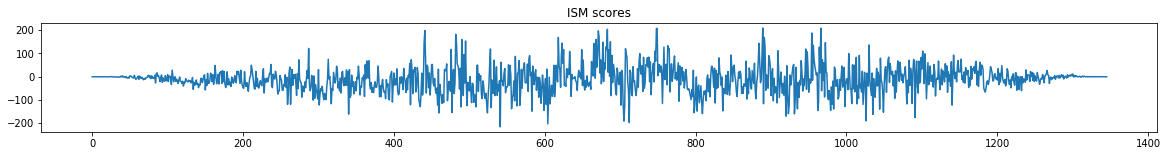

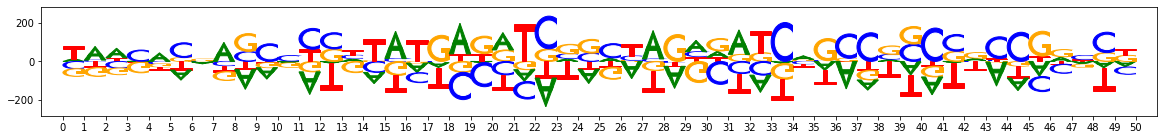

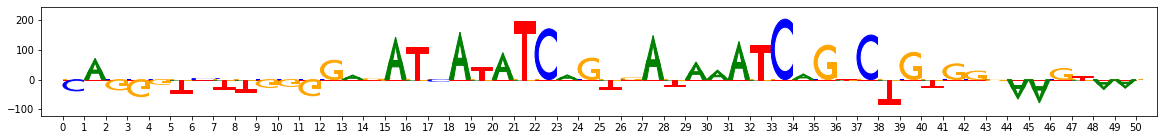

Input gradients and Fourier transform


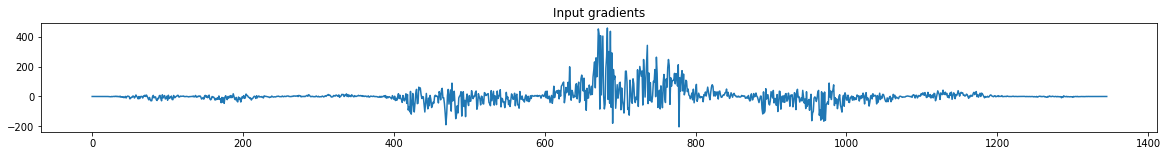

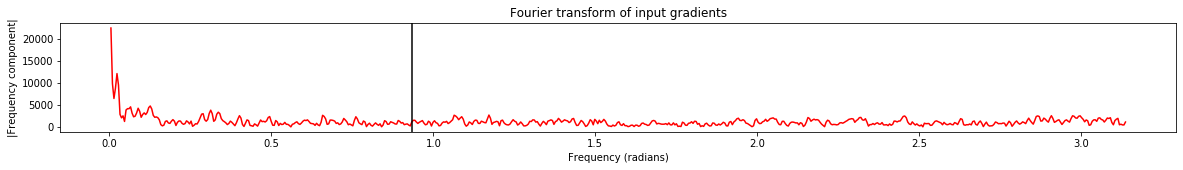

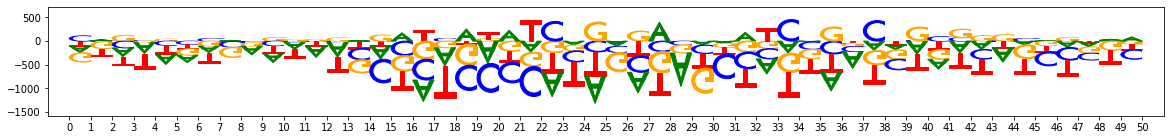

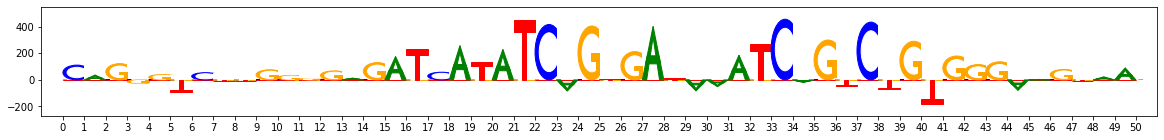

SHAP scores


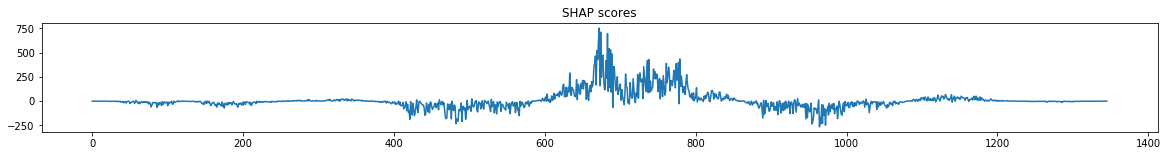

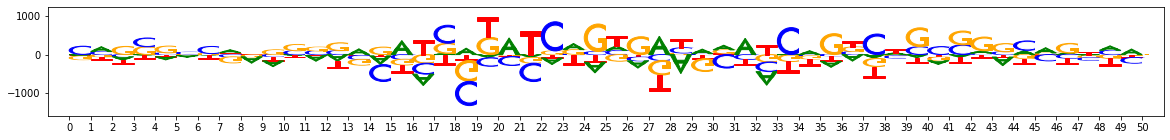

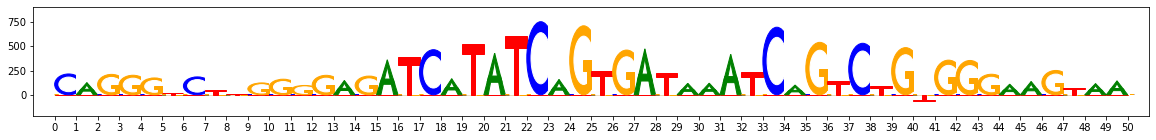

ISM scores


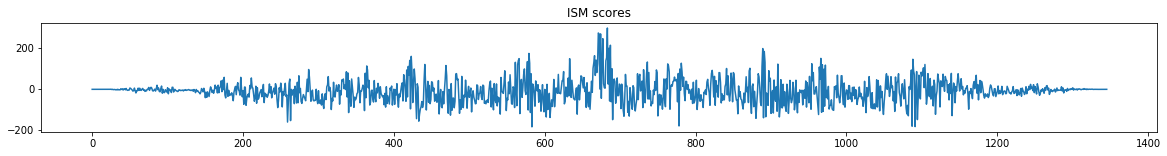

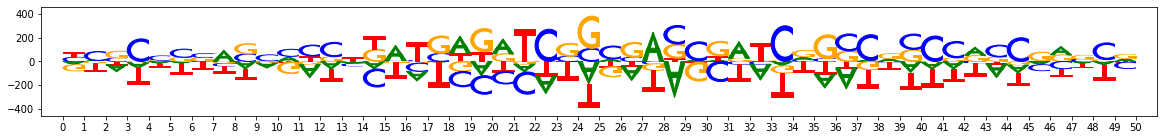

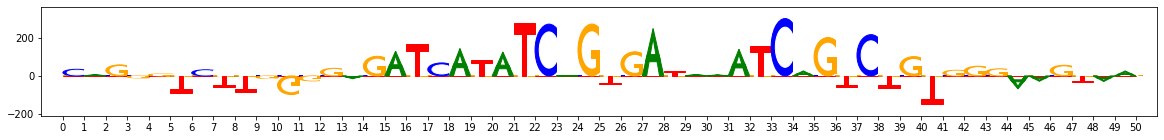

In [65]:
# GATA2
chrom, start, end = 'chr1', 244113481, 244113921
seq_slice = slice(650, 700)
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, show_sequences, seq_slice)

Input gradients and Fourier transform


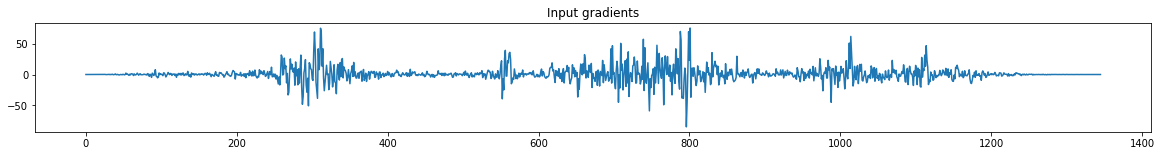

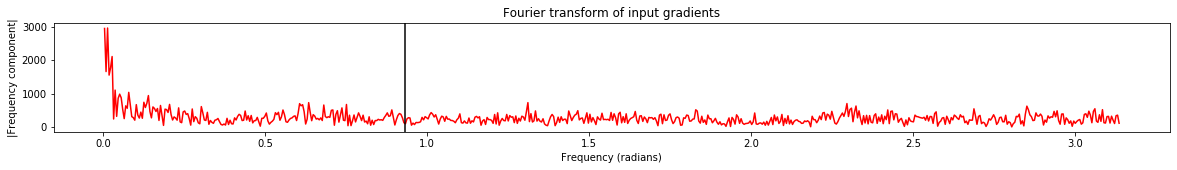

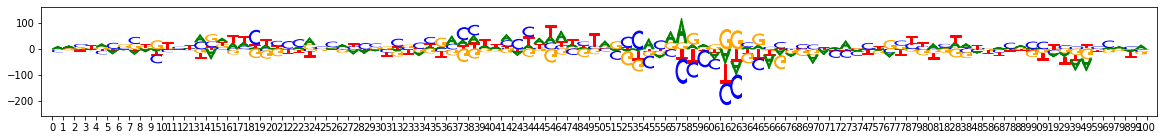

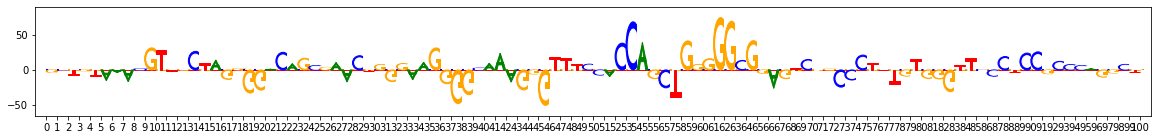

SHAP scores


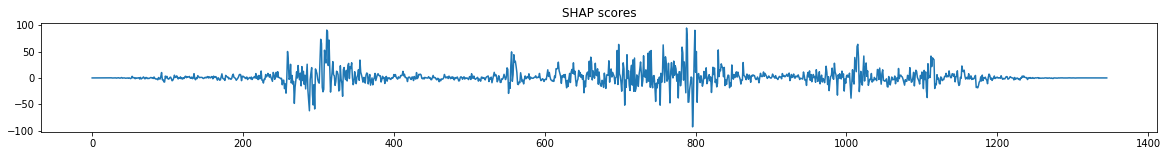

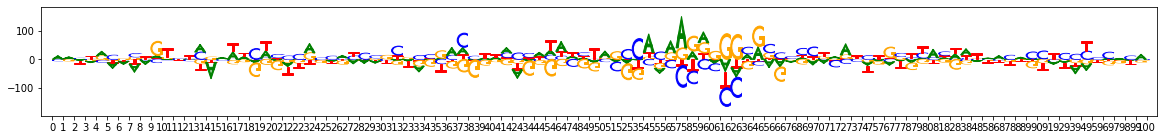

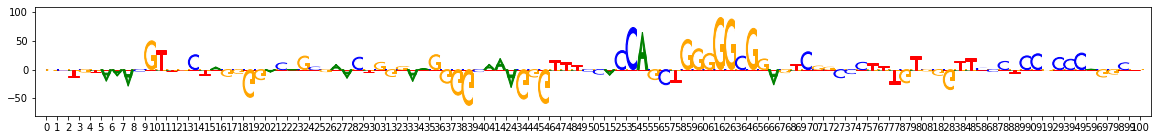

ISM scores


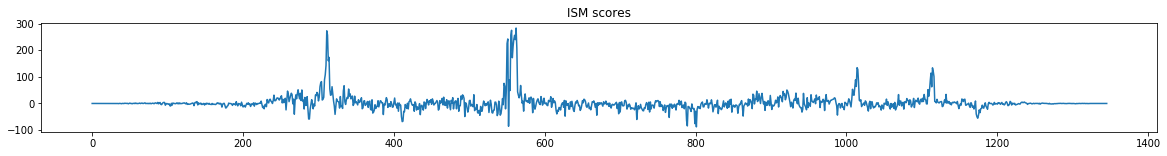

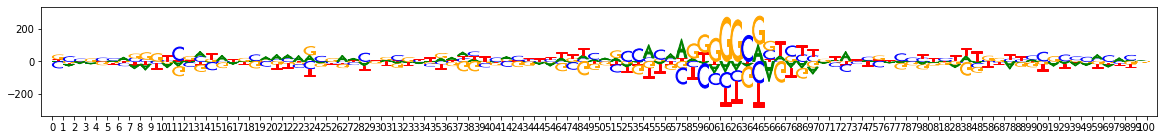

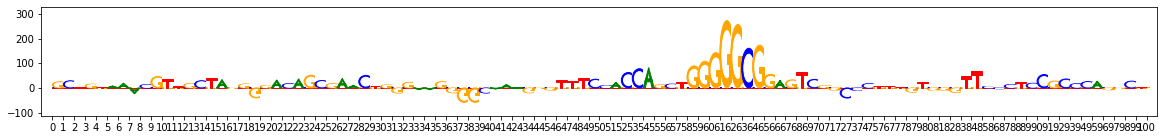

Input gradients and Fourier transform


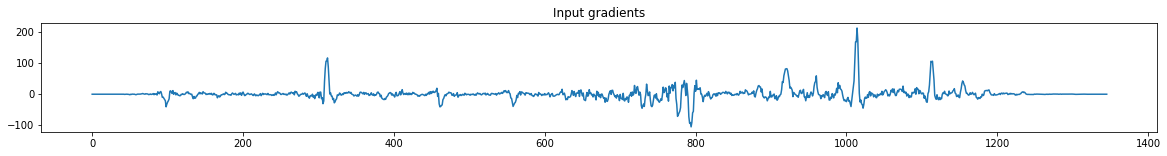

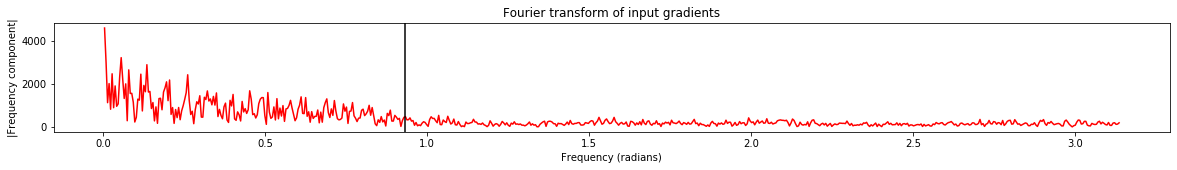

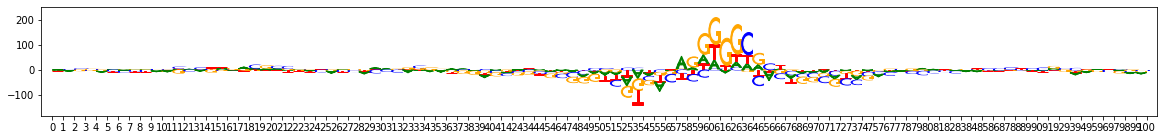

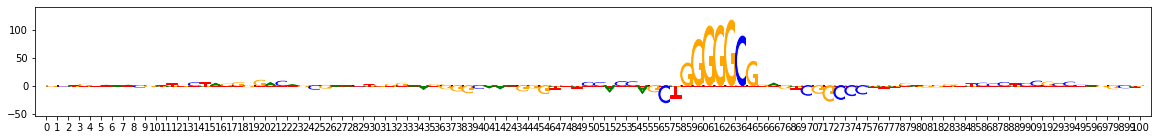

SHAP scores


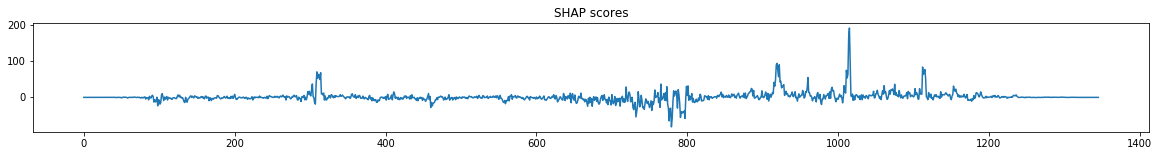

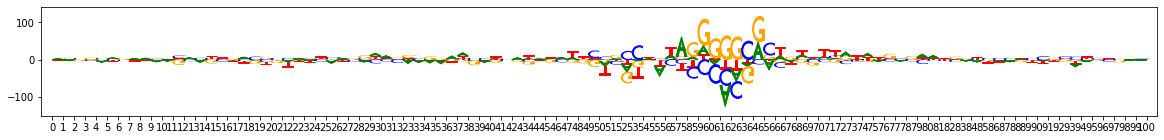

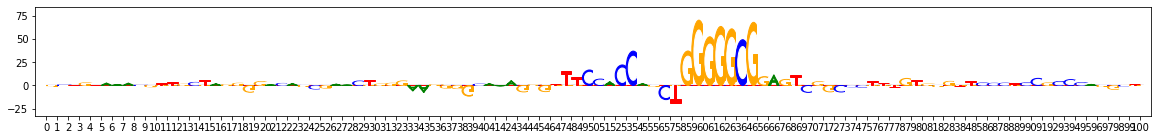

ISM scores


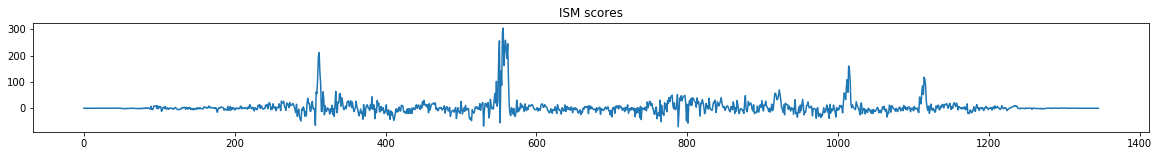

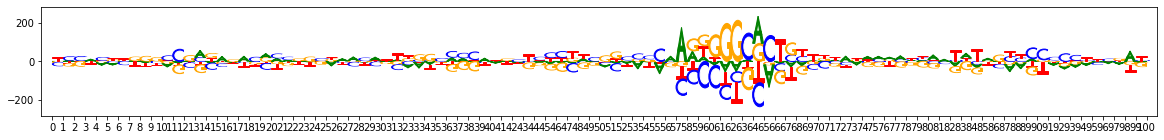

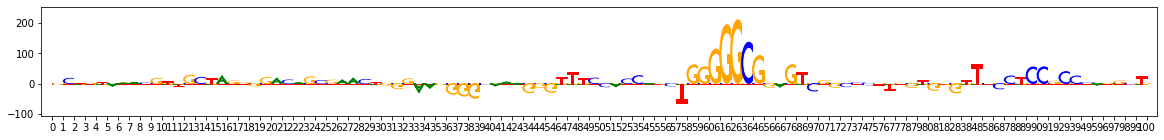

In [22]:
# K562
chrom, start, end = 'chr1', 212698970, 212700121
seq_slice = slice(250, 350)
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, show_sequences, seq_slice)

Input gradients and Fourier transform


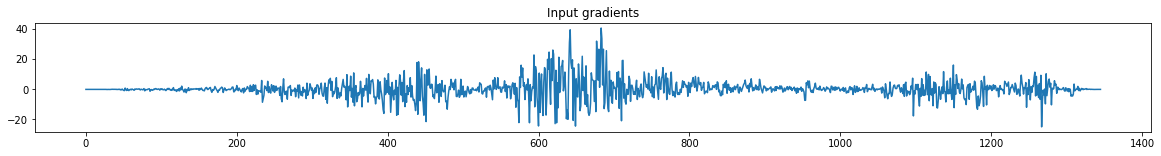

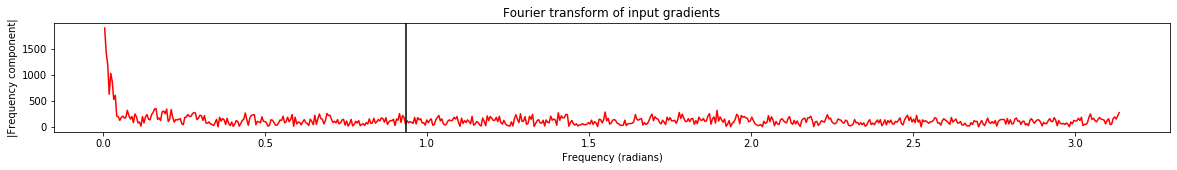

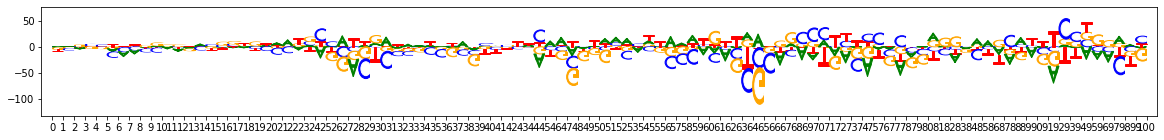

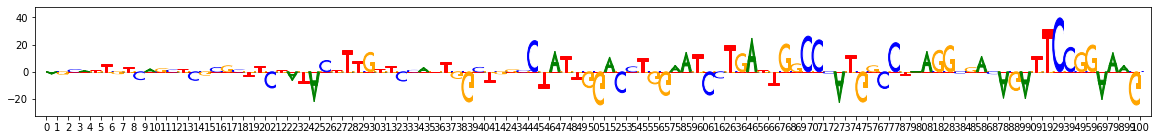

SHAP scores


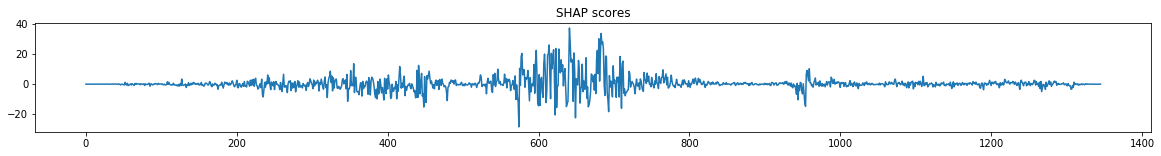

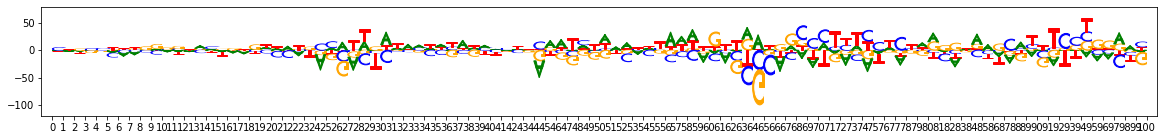

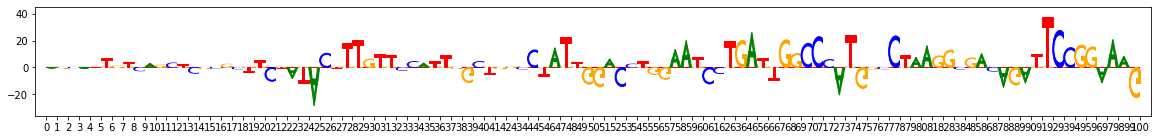

ISM scores


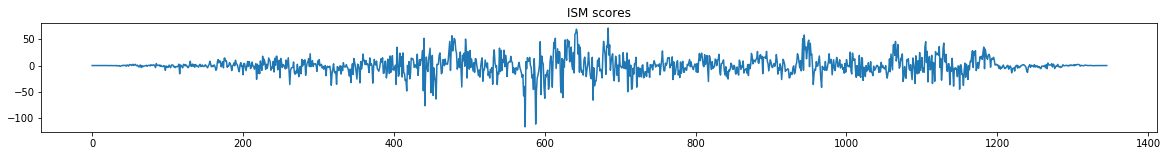

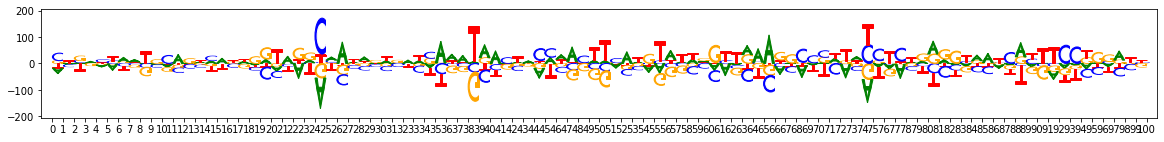

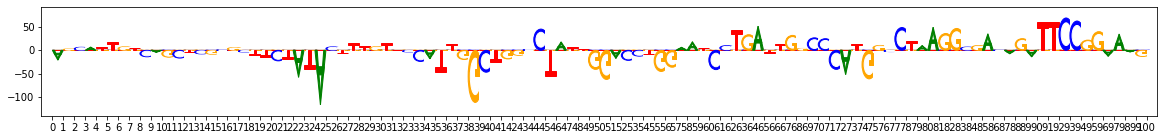

Input gradients and Fourier transform


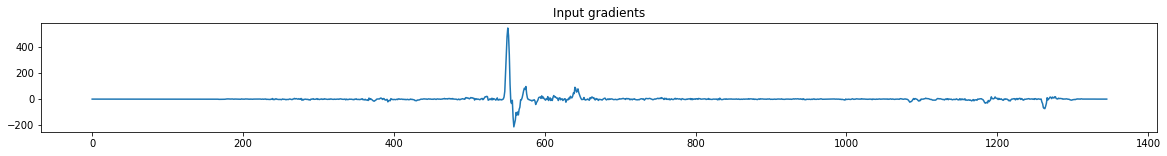

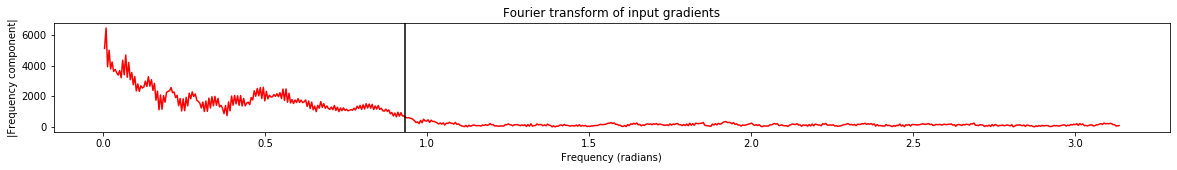

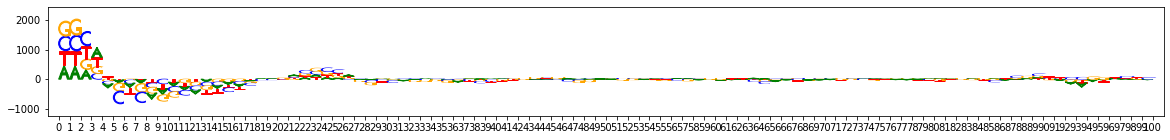

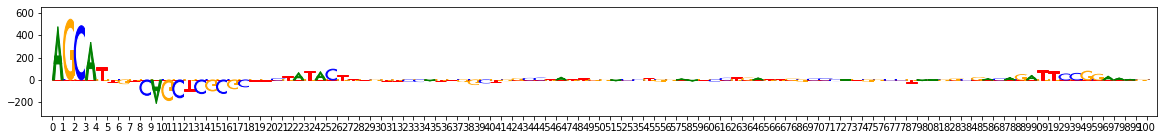

SHAP scores


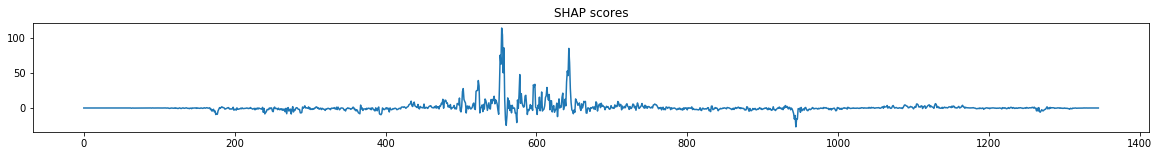

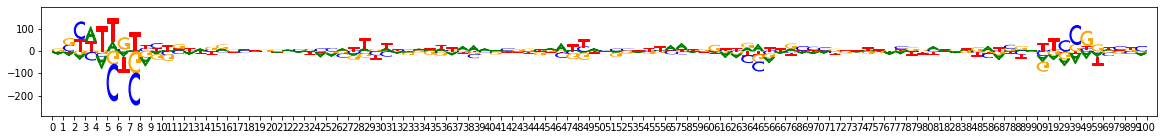

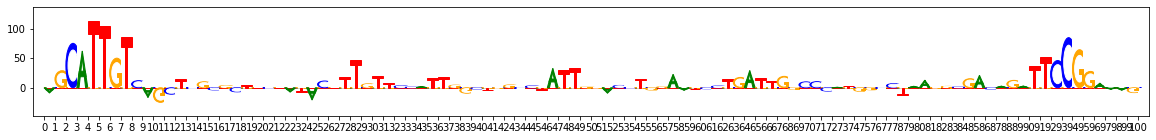

ISM scores


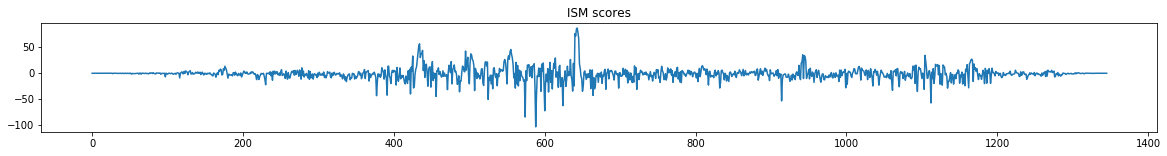

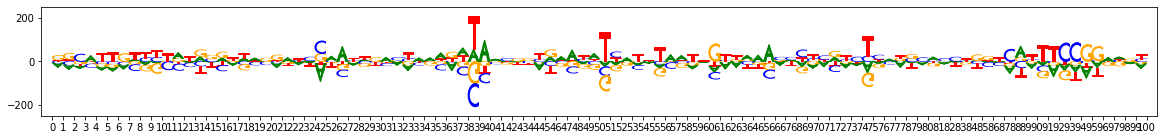

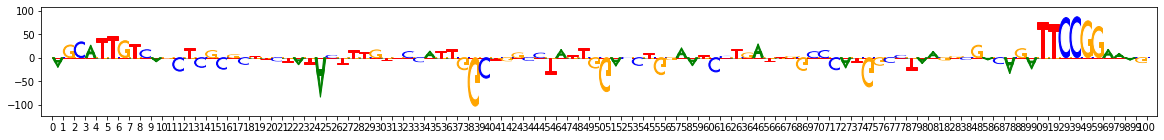

In [109]:
# BPNet
chrom, start, end = 'chr1', 93343494, 93343838
seq_slice = slice(550, 650)
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, show_sequences, seq_slice)